In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob

In [ ]:
# Constants
RTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\RTM_images'
DTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\DTM_images'
ATM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\ATM_images'
SOR_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\Signal_Variation_SOR'
SOT_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\Signal_Variation_SOT'
var_2d = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\Signal_Variation_2D'

IMG_SIZE = (32, 32)
SEQ_LEN = 5

In [3]:
# === Utility: Loaders ===
def load_modality_file(path):
    if path.endswith(".npy"):
        try:
            arr = np.load(path)
            arr = np.resize(arr, IMG_SIZE)  # Resize to (32, 32)
            return arr[:, :, np.newaxis].astype(np.uint8)
        except Exception as e:
            print(f"[Error loading .npy] {path} → {e}")
            return np.zeros((*IMG_SIZE, 1), dtype=np.uint8)
    else:
        img = load_img(path, color_mode='grayscale', target_size=IMG_SIZE)
        return img_to_array(img).astype(np.uint8)

# === Index Dataset (6 modalities now) ===
def index_sequences(rtm_path, dtm_path, atm_path, sor_path, sot_path, var_2d_path, seq_len=5, exclude=None):
    train, test, gestures = [], [], set()
    exclude = set(exclude or [])

    for person in sorted(os.listdir(rtm_path)):
        target = test if person in exclude else train
        for session in os.listdir(os.path.join(rtm_path, person)):
            for gesture in os.listdir(os.path.join(rtm_path, person, session)):
                rtm_files = sorted(glob(os.path.join(rtm_path, person, session, gesture, '*.png')))
                dtm_files = sorted(glob(os.path.join(dtm_path, person, session, gesture, '*.png')))
                atm_files = sorted(glob(os.path.join(atm_path, person, session, gesture, '*.png')))
                sor_files = sorted(glob(os.path.join(sor_path, person, session, gesture, '*.npy')))
                sot_files = sorted(glob(os.path.join(sot_path, person, session, gesture, '*.npy')))
                var_files = sorted(glob(os.path.join(var_2d_path, person, session, gesture, '*.npy')))

                n = min(len(rtm_files), len(dtm_files), len(atm_files), len(sor_files), len(sot_files), len(var_files))
                gestures.add(gesture)
                for i in range(n - seq_len + 1):
                    target.append({
                        'rtm': rtm_files[i:i+seq_len],
                        'dtm': dtm_files[i:i+seq_len],
                        'atm': atm_files[i:i+seq_len],
                        'sor': sor_files[i:i+seq_len],
                        'sot': sot_files[i:i+seq_len],
                        'var': var_files[i:i+seq_len],
                        'label': gesture
                    })

    label_map = {g: i for i, g in enumerate(sorted(gestures))}
    train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)
    return train_data, val_data, test, label_map

# === Data Generator (6 modalities now) ===
class SingleInputSequence(Sequence):
    def __init__(self, samples, label_map, batch_size=64, seq_len=5, shuffle_data=False):
        self.samples = samples
        self.label_map = label_map
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.shuffle_data = shuffle_data
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle_data:
            self.samples = shuffle(self.samples)

    def __getitem__(self, idx):
        batch = self.samples[idx * self.batch_size: (idx + 1) * self.batch_size]
        X, y = [], []
        for sample in batch:
            rtm = [load_modality_file(p) for p in sample['rtm']]
            dtm = [load_modality_file(p) for p in sample['dtm']]
            atm = [load_modality_file(p) for p in sample['atm']]
            sor = [load_modality_file(p) for p in sample['sor']]
            sot = [load_modality_file(p) for p in sample['sot']]
            var = [load_modality_file(p) for p in sample['var']]

            # Concatenate vertically along height (shared width = 32)
            sequence = np.concatenate(rtm + dtm + atm + sor + sot + var, axis=0)  # shape: (6*5*32, 32, 1)
            X.append(sequence)
            y.append(self.label_map[sample['label']])
        X = np.array(X).astype(np.float32) / 255.0  # Normalize to [0, 1]
        return X, np.array(y)

In [4]:
def build_stm32_deployable_model(input_shape=(960, 32, 1), num_classes=13):
    inputs = tf.keras.Input(shape=input_shape, name="input")

    # === 1. Split Input ===
    rtm = layers.Cropping2D(((0, 800), (0, 0)))(inputs)        # 0:160
    dtm = layers.Cropping2D(((160, 640), (0, 0)))(inputs)      # 160:320
    atm = layers.Cropping2D(((320, 480), (0, 0)))(inputs)      # 320:480
    sor = layers.Cropping2D(((480, 320), (0, 0)))(inputs)      # 480:640
    sot = layers.Cropping2D(((640, 160), (0, 0)))(inputs)      # 640:800
    var = layers.Cropping2D(((800, 0), (0, 0)))(inputs)        # 800:960

    def cnn_branch():
        inp = tf.keras.Input(shape=(160, 32, 1))
        x = layers.Conv2D(16, 3, activation='relu', padding='same')(inp)
        x = layers.DepthwiseConv2D(3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(2)(x)  # → 80×16×16

        x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(2)(x)  # → 40×8×32

        x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = layers.GlobalAveragePooling2D()(x)  # → (64,)
        return tf.keras.Model(inp, x)

    branch = cnn_branch()

    # === 2. Feature extraction for each modality ===
    feat_rtm = branch(rtm)
    feat_dtm = branch(dtm)
    feat_atm = branch(atm)
    feat_sor = branch(sor)
    feat_sot = branch(sot)
    feat_var = branch(var)

    # === 3. Temporal Fusion ===
    x = layers.Concatenate()([feat_rtm, feat_dtm, feat_atm, feat_sor, feat_sot, feat_var])  # → (384,)
    x = layers.Reshape((6, 64))(x)  # (6 time steps, 64 features)

    x = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)

    # === 4. MLP Head ===
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [5]:
# === Updated exclusion list ===
excluded = {f'p0_{i}' for i in range(15, 21)}  # Exclude p0_15 to p0_20

# === Updated dataset indexing with all 6 modalities ===
train_samples, val_samples, test_samples, label_map = index_sequences(
    rtm_path=RTM_PATH,
    dtm_path=DTM_PATH,
    atm_path=ATM_PATH,
    sor_path=SOR_PATH,
    sot_path=SOT_PATH,
    var_2d_path=var_2d,               # <- Add the new modality path
    seq_len=SEQ_LEN,
    exclude=excluded
)

# === Updated generator for 6-modality input ===
train_gen = SingleInputSequence(train_samples, label_map, batch_size=32, shuffle_data=True)
val_gen = SingleInputSequence(val_samples, label_map, batch_size=32, shuffle_data=False)

In [6]:
model = build_stm32_deployable_model(input_shape=(960, 32, 1), num_classes=13)
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 960, 32, 1)]         0         []                            
                                                                                                  
 cropping2d (Cropping2D)     (None, 160, 32, 1)           0         ['input[0][0]']               
                                                                                                  
 cropping2d_1 (Cropping2D)   (None, 160, 32, 1)           0         ['input[0][0]']               
                                                                                                  
 cropping2d_2 (Cropping2D)   (None, 160, 32, 1)           0         ['input[0][0]']               
                                                                                          

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os

# === Directory for saving checkpoints ===
os.makedirs("var_checkpoints", exist_ok=True)

# === Save best model with val_acc and epoch in name ===
checkpoint_cb = ModelCheckpoint(
    filepath="var_checkpoints/best_model_epoch{epoch:02d}_valacc{val_accuracy:.4f}.h5",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode='max'
)

# === Compile model ===
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# === Train and store history ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint_cb]
)


Epoch 1/50


203/203 [==============================] - ETA: 0s - loss: 1.9644 - accuracy: 0.2805
Epoch 1: val_accuracy improved from -inf to 0.36414, saving model to var_checkpoints\best_model_epoch01_valacc0.3641.h5
203/203 [==============================] - 867s 4s/step - loss: 1.9644 - accuracy: 0.2805 - val_loss: 1.7023 - val_accuracy: 0.3641
Epoch 2/50


c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


203/203 [==============================] - ETA: 0s - loss: 1.5883 - accuracy: 0.4164
Epoch 2: val_accuracy improved from 0.36414 to 0.42699, saving model to var_checkpoints\best_model_epoch02_valacc0.4270.h5
203/203 [==============================] - 868s 4s/step - loss: 1.5883 - accuracy: 0.4164 - val_loss: 1.5807 - val_accuracy: 0.4270
Epoch 3/50
203/203 [==============================] - ETA: 0s - loss: 1.5284 - accuracy: 0.4219
Epoch 3: val_accuracy improved from 0.42699 to 0.42822, saving model to var_checkpoints\best_model_epoch03_valacc0.4282.h5
203/203 [==============================] - 943s 5s/step - loss: 1.5284 - accuracy: 0.4219 - val_loss: 1.4804 - val_accuracy: 0.4282
Epoch 4/50
203/203 [==============================] - ETA: 0s - loss: 1.4209 - accuracy: 0.4622
Epoch 4: val_accuracy did not improve from 0.42822
203/203 [==============================] - 712s 4s/step - loss: 1.4209 - accuracy: 0.4622 - val_loss: 1.4534 - val_accuracy: 0.4110
Epoch 5/50
203/203 [==========

In [9]:
# load best keras model 
model = tf.keras.models.load_model("var_checkpoints/best_model_epoch48_valacc0.8731.h5")

In [11]:
model.save('deployable_cnn_var_model.h5')

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

1/1 [==============================] - 0s 167ms/step


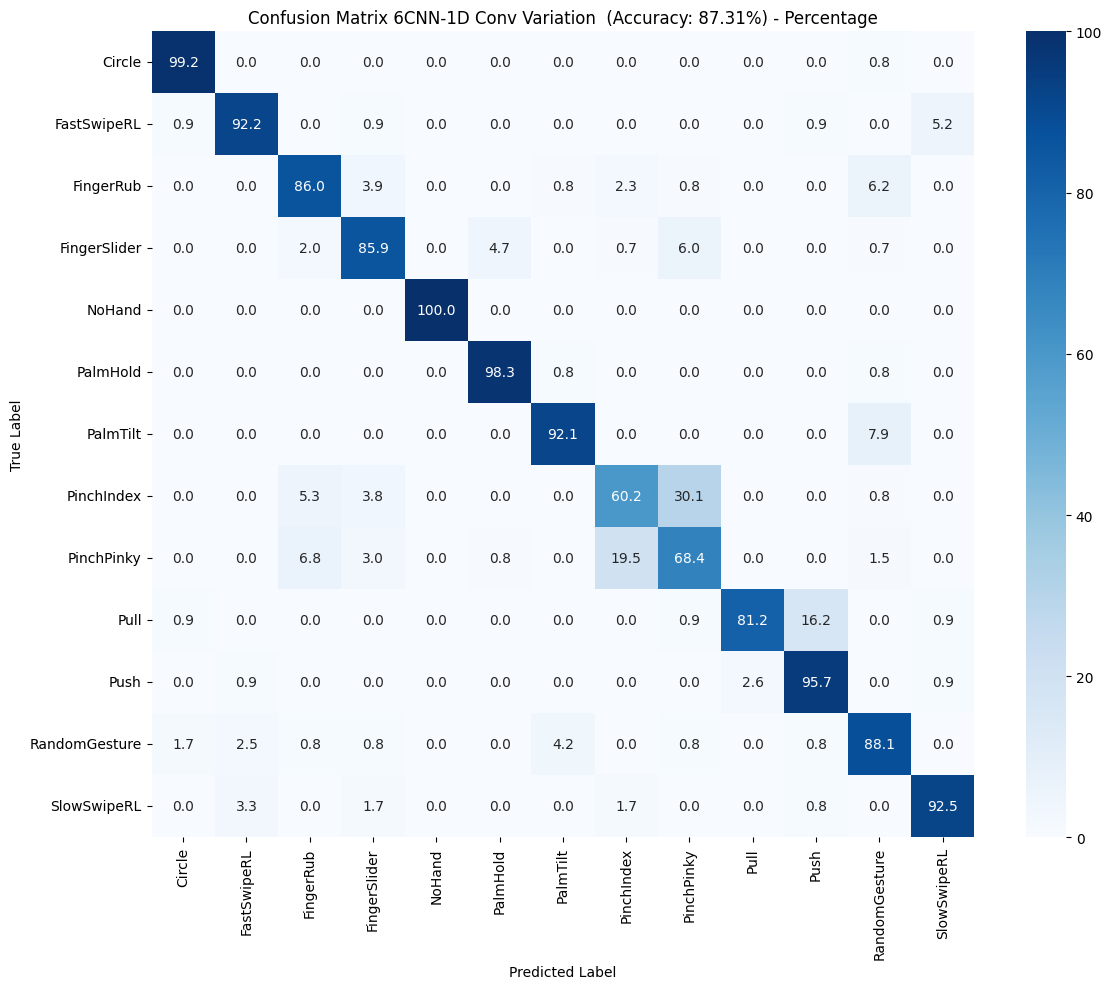

               precision    recall  f1-score   support

       Circle      0.968     0.992     0.980       123
  FastSwipeRL      0.930     0.922     0.926       115
    FingerRub      0.847     0.860     0.854       129
 FingerSlider      0.877     0.859     0.868       149
       NoHand      1.000     1.000     1.000       124
     PalmHold      0.936     0.983     0.959       119
     PalmTilt      0.944     0.921     0.932       127
   PinchIndex      0.714     0.602     0.653       133
   PinchPinky      0.636     0.684     0.659       133
         Pull      0.969     0.812     0.884       117
         Push      0.835     0.957     0.892       116
RandomGesture      0.812     0.881     0.846       118
  SlowSwipeRL      0.933     0.925     0.929       120

     accuracy                          0.873      1623
    macro avg      0.877     0.877     0.875      1623
 weighted avg      0.874     0.873     0.872      1623



In [13]:
exclude_labels = {}
label_to_idx = {label: idx for label, idx in label_map.items() if label not in exclude_labels}
idx_to_label = {v: k for k, v in label_to_idx.items()}

# Inverse mapping for lookup
valid_indices = set(label_to_idx.values())

y_true, y_pred = [], []
for X, y in val_gen:
    preds = model.predict(X)
    for true_label, pred_logits in zip(y, preds):
        if int(true_label) in valid_indices:
            y_true.append(int(true_label))
            y_pred.append(np.argmax(pred_logits))

# Reindex labels to remove gaps caused by excluded labels
original_to_new_idx = {old: new for new, old in enumerate(sorted(valid_indices))}
new_class_names = [idx_to_label[i] for i in sorted(valid_indices)]

# Remap y_true and y_pred
y_true_mapped = [original_to_new_idx[y] for y in y_true]
y_pred_mapped = [original_to_new_idx[y] for y in y_pred]

# Metrics
cm = confusion_matrix(y_true_mapped, y_pred_mapped)
acc = accuracy_score(y_true_mapped, y_pred_mapped)
report = classification_report(y_true_mapped, y_pred_mapped, target_names=new_class_names, digits=3)

# Normalize the confusion matrix row-wise to get percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=new_class_names, yticklabels=new_class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix 6CNN-1D Conv Variation  (Accuracy: {acc:.2%}) - Percentage")
plt.tight_layout()
plt.show()

# Print classification report
print(report)

# Converting to TFLite

In [ ]:
# Reload it to ensure clean state
# model = tf.keras.models.load_model("deployable_cnn_var_model.h5")
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.evaluate(val_gen)

13/13 [==============================] - 7s 438ms/step - loss: 0.5506 - accuracy: 0.7831


[0.5506397485733032, 0.7831177115440369]

In [14]:
# === Wrap with fixed batch size ===
fixed_input = tf.keras.Input(batch_input_shape=(1, 960, 32, 1), name="input")
fixed_output = model(fixed_input)
wrapped_model = tf.keras.Model(inputs=fixed_input, outputs=fixed_output)

# === Save as TFLite ===
converter = tf.lite.TFLiteConverter.from_keras_model(wrapped_model)
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()
with open("deployable_cnn_var_model_float32.tflite", "wb") as f:
    f.write(tflite_model)

print(" Model wrapped and saved with fixed batch size: (1, 960, 32, 1)")

INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpauoc2_yv\assets


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpauoc2_yv\assets


 Model wrapped and saved with fixed batch size: (1, 960, 32, 1)


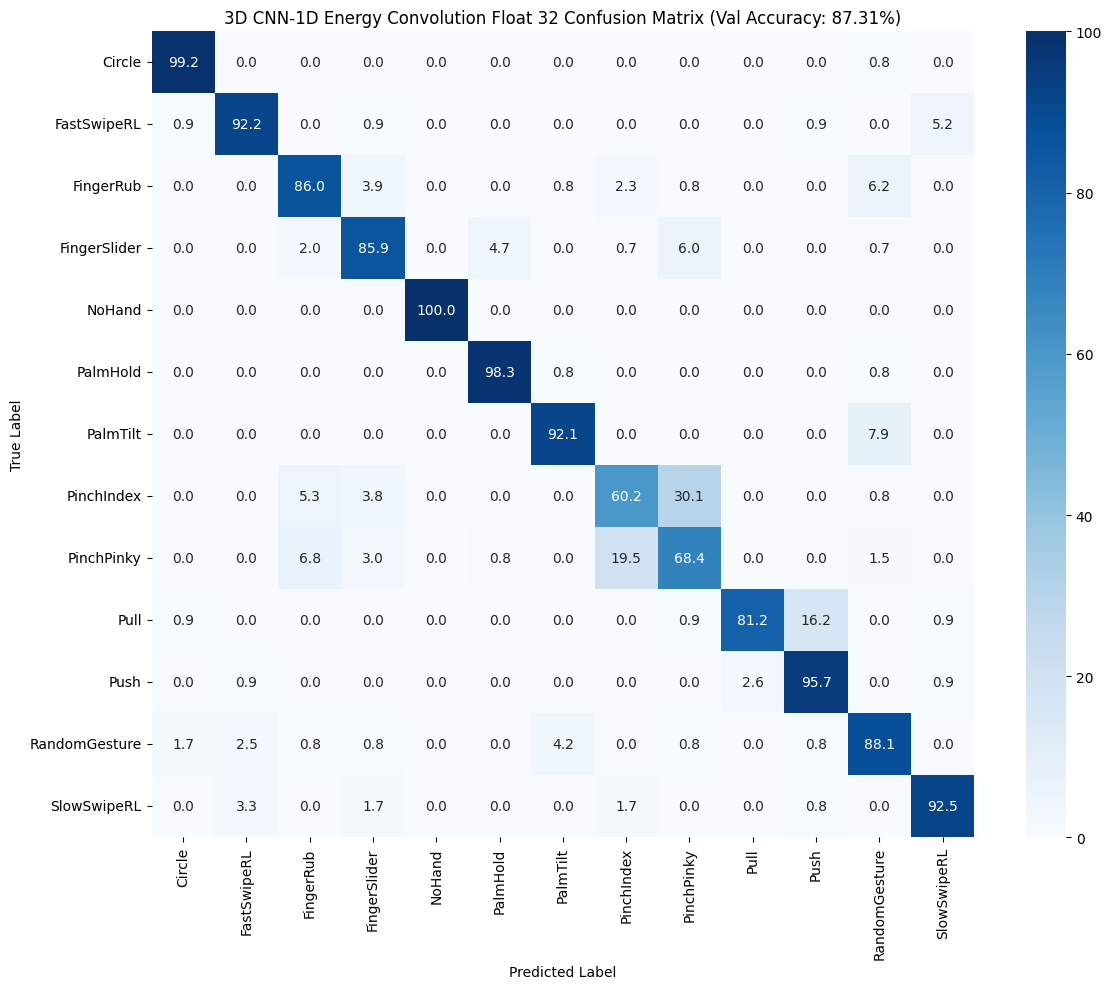

Classification Report:
                precision    recall  f1-score   support

       Circle      0.968     0.992     0.980       123
  FastSwipeRL      0.930     0.922     0.926       115
    FingerRub      0.847     0.860     0.854       129
 FingerSlider      0.877     0.859     0.868       149
       NoHand      1.000     1.000     1.000       124
     PalmHold      0.936     0.983     0.959       119
     PalmTilt      0.944     0.921     0.932       127
   PinchIndex      0.714     0.602     0.653       133
   PinchPinky      0.636     0.684     0.659       133
         Pull      0.969     0.812     0.884       117
         Push      0.835     0.957     0.892       116
RandomGesture      0.812     0.881     0.846       118
  SlowSwipeRL      0.933     0.925     0.929       120

     accuracy                          0.873      1623
    macro avg      0.877     0.877     0.875      1623
 weighted avg      0.874     0.873     0.872      1623



In [15]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="deployable_cnn_var_model_float32.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to predict using TFLite
def predict_tflite_sequence(sequence):
    # Ensure float32 and normalized
    sequence = sequence.astype(np.float32)
    # Add batch dimension
    input_tensor = np.expand_dims(sequence, axis=0)  
    # Set tensor and invoke
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    # Extract prediction
    output = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output, axis=1)[0]

# Evaluate on val set
y_true, y_pred = [], []
for X, y in val_gen:
    for i in range(len(X)):
        pred = predict_tflite_sequence(X[i])
        y_true.append(int(y[i]))
        y_pred.append(int(pred))

# Get full label list
idx_to_label = {v: k for k, v in label_map.items()}
class_names = [idx_to_label[i] for i in range(len(label_map))]

# Metrics
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)

# Normalize CM to show percentages
cm_percent = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True) * 100

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"3D CNN-1D Energy Convolution Float 32 Confusion Matrix (Val Accuracy: {acc:.2%})")
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:\n", report)

# Quantizing to Int8

In [16]:
# === Fixed batch-size wrapper ===
fixed_input = tf.keras.Input(batch_input_shape=(1, 960, 32, 1), name="input")
fixed_output = model(fixed_input)
wrapped_model = tf.keras.Model(inputs=fixed_input, outputs=fixed_output)

# === Representative dataset: yield one sample with correct shape (1, 960, 32, 1) ===
def representative_dataset():
    for i in range(100):
        x, _ = train_gen[i]
        for sample in x:
            sample = sample.astype(np.float32)
            yield [np.expand_dims(sample, axis=0)]  # shape: (1, 960, 32, 1)

# === Convert model to full INT8 with fixed shape ===
converter = tf.lite.TFLiteConverter.from_keras_model(wrapped_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Convert and save
tflite_model = converter.convert()
with open("deployable_cnn_var_model_int8.tflite", "wb") as f:
    f.write(tflite_model)

print("Full INT8 TFLite model saved with fixed batch size: (1, 960, 32, 1)")


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpkw0i0bz8\assets


INFO:tensorflow:Assets written to: C:\Users\ioana\AppData\Local\Temp\tmpkw0i0bz8\assets
c:\Users\ioana\anaconda3\envs\tiny_radar\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Full INT8 TFLite model saved with fixed batch size: (1, 960, 32, 1)


Testing

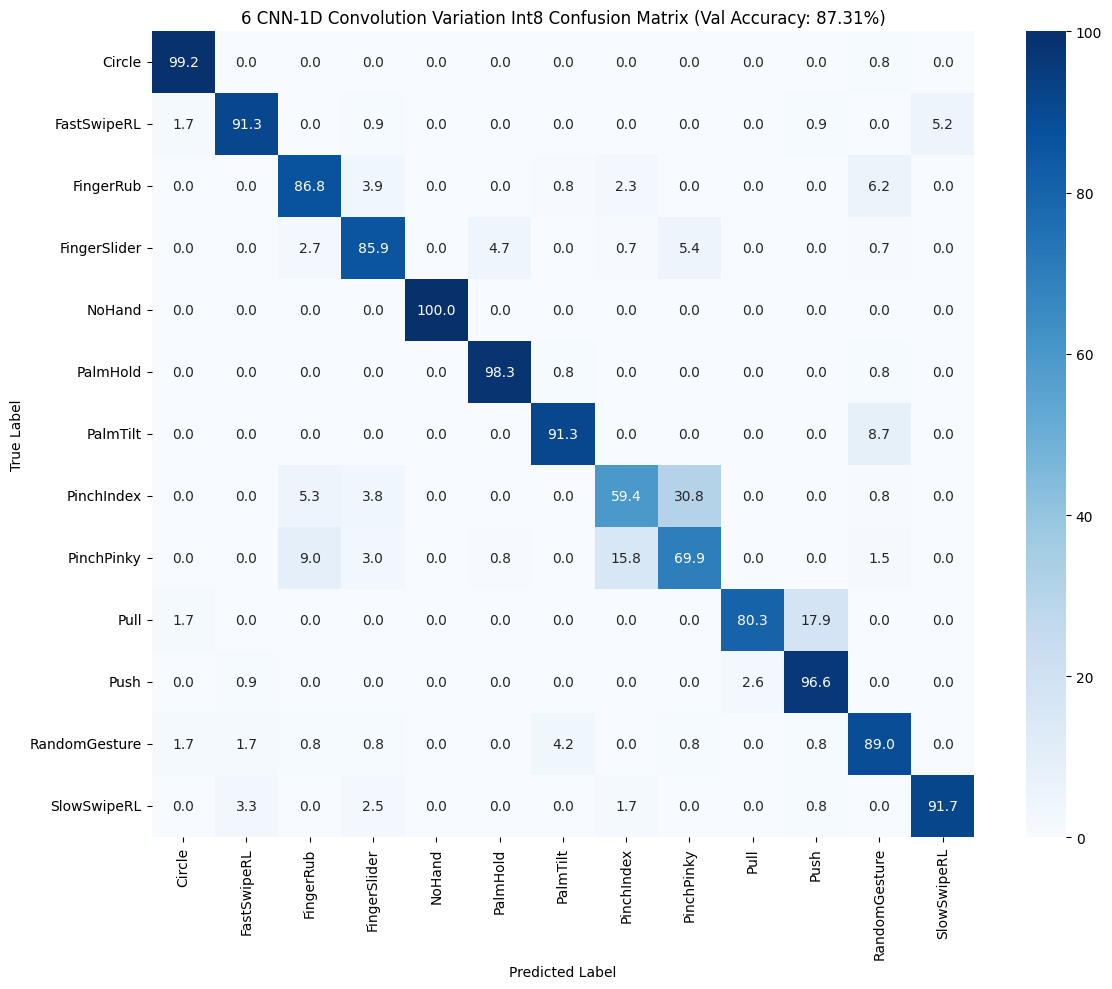

Classification Report:
                precision    recall  f1-score   support

       Circle      0.953     0.992     0.972       123
  FastSwipeRL      0.938     0.913     0.925       115
    FingerRub      0.824     0.868     0.845       129
 FingerSlider      0.871     0.859     0.865       149
       NoHand      1.000     1.000     1.000       124
     PalmHold      0.936     0.983     0.959       119
     PalmTilt      0.943     0.913     0.928       127
   PinchIndex      0.745     0.594     0.661       133
   PinchPinky      0.650     0.699     0.674       133
         Pull      0.969     0.803     0.879       117
         Push      0.824     0.966     0.889       116
RandomGesture      0.808     0.890     0.847       118
  SlowSwipeRL      0.948     0.917     0.932       120

     accuracy                          0.873      1623
    macro avg      0.878     0.877     0.875      1623
 weighted avg      0.875     0.873     0.872      1623



In [17]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\deployable_cnn_var_model_int8.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to predict using TFLite
def predict_tflite_sequence(sequence):
    # Get scale and zero-point for quantization
    scale, zero_point = input_details[0]['quantization']

    # Normalize input (assuming it was float32 [0,1])
    sequence = sequence.astype(np.float32)

    # Quantize to int8
    sequence_q = (sequence / scale + zero_point).astype(np.int8)
    input_tensor = np.expand_dims(sequence_q, axis=0)  # Add batch dim

    # Set and run
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()

    # Dequantize output if needed
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output_data, axis=1)[0]

# Evaluate on val set
y_true, y_pred = [], []
for X, y in val_gen:
    for i in range(len(X)):
        pred = predict_tflite_sequence(X[i])
        y_true.append(int(y[i]))
        y_pred.append(int(pred))

# Get full label list
idx_to_label = {v: k for k, v in label_map.items()}
class_names = [idx_to_label[i] for i in range(len(label_map))]

# Metrics
cm = confusion_matrix(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)

# Normalize CM to show percentages
cm_percent = cm.astype(np.float32) / cm.sum(axis=1, keepdims=True) * 100

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"6 CNN-1D Convolution Variation Int8 Confusion Matrix (Val Accuracy: {acc:.2%})")
plt.tight_layout()
plt.show()

# Print classification report
print("Classification Report:\n", report)

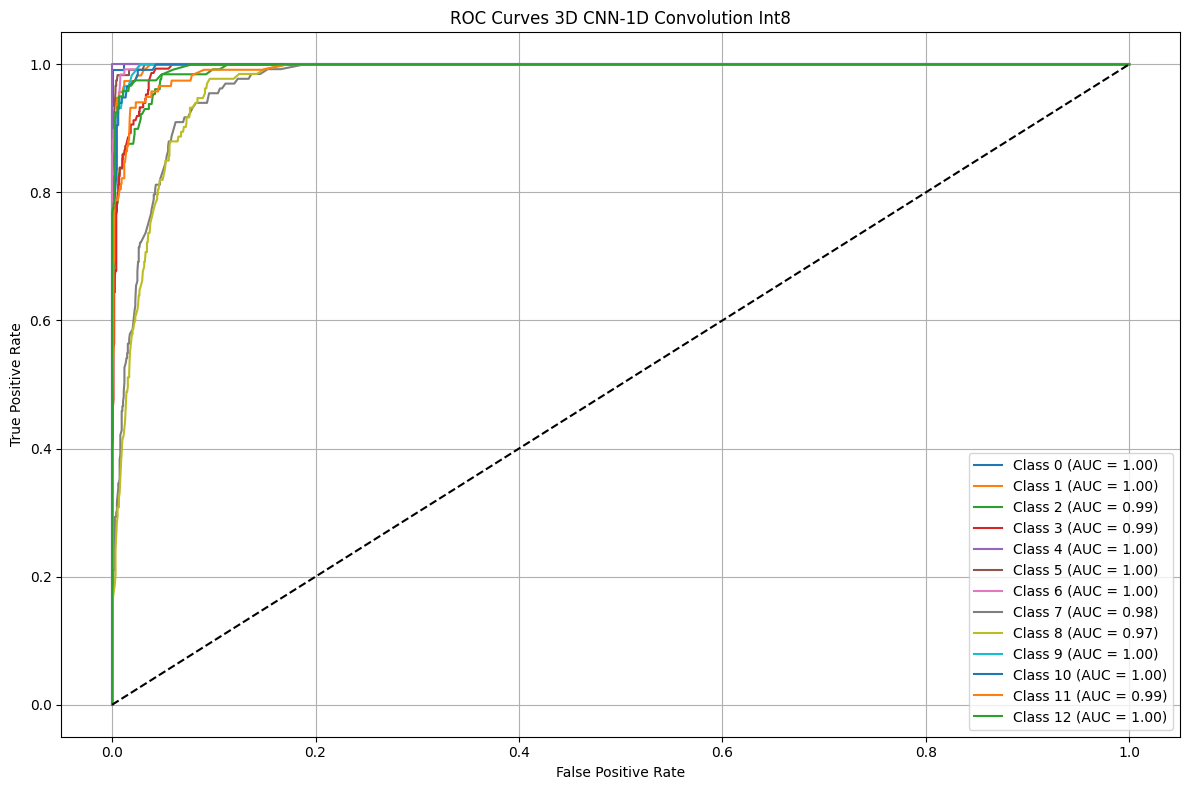

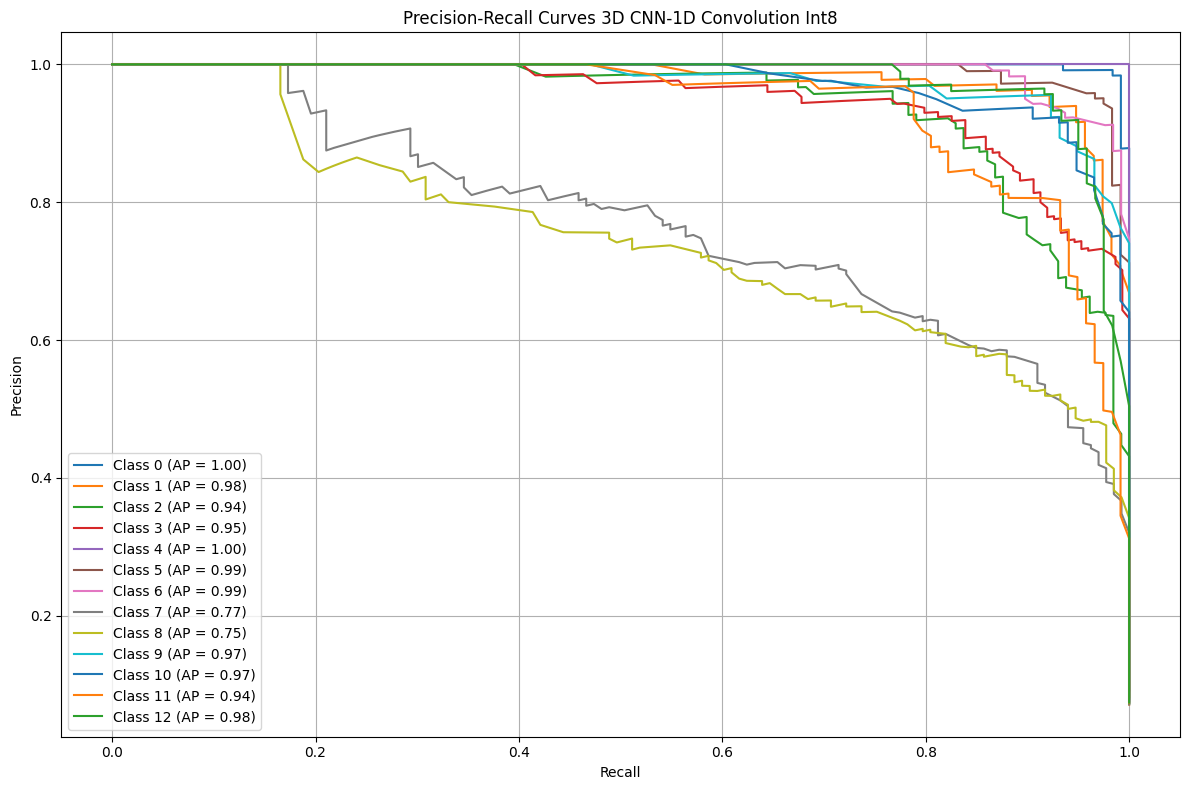

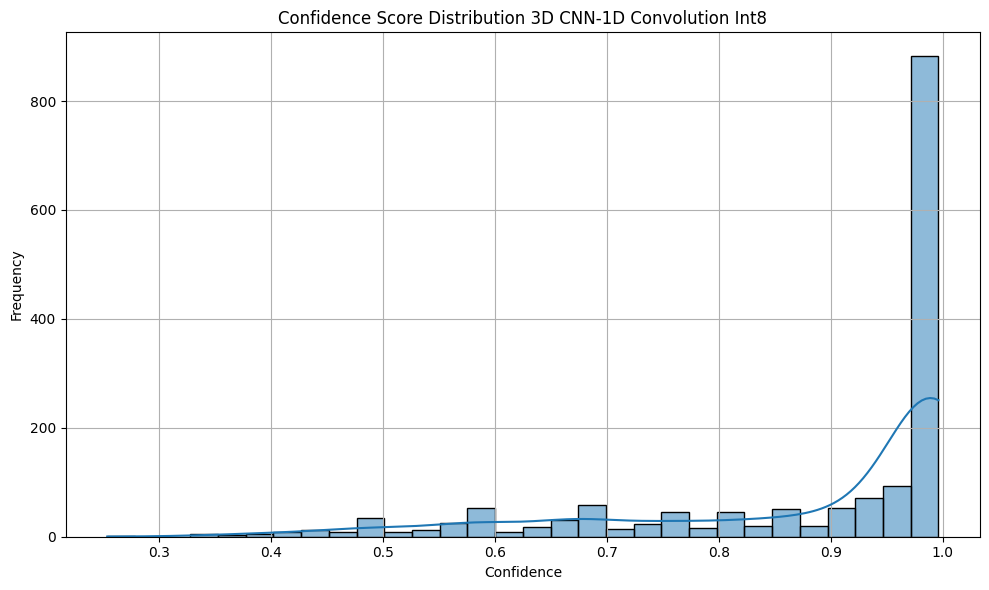

In [18]:
# Load TFLite model
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

interpreter = tf.lite.Interpreter(model_path=r"C:\Users\ioana\Documents\VS Projects\ML-on-Microcontrollers-Project-Ioana-Gidiuta\Code\model_training_grayscale_images\deployable_cnn_var_model_int8.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_tflite_proba(sequence):
    # Quantization parameters for the input
    scale, zero_point = input_details[0]['quantization']
    
    # Quantize float32 input to int8
    input_tensor = (sequence / scale + zero_point).astype(np.int8)
    input_tensor = np.expand_dims(input_tensor, axis=0)  # Add batch dimension

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()

    # Dequantize output (optional but useful for ROC/PR curves)
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]
    out_scale, out_zero_point = output_details[0]['quantization']
    output_dequant = (output_data.astype(np.float32) - out_zero_point) * out_scale

    return output_dequant

# Gather predictions and scores
y_true, y_scores = [], []
for X_batch, y_batch in val_gen:
    for i in range(len(X_batch)):
        y_true.append(int(y_batch[i]))
        y_scores.append(predict_tflite_proba(X_batch[i]))

y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_pred = np.argmax(y_scores, axis=1)

# Convert labels to one-hot for metrics
n_classes = len(label_map)
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# ROC Curve
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves 3D CNN-1D Convolution Int8")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_scores[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_scores[:, i])
    plt.plot(recall, precision, label=f"Class {i} (AP = {avg_precision:.2f})")
plt.title("Precision-Recall Curves 3D CNN-1D Convolution Int8")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Confidence Score Distribution
conf_scores = np.max(y_scores, axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(conf_scores, bins=30, kde=True)
plt.title("Confidence Score Distribution 3D CNN-1D Convolution Int8")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid()
plt.show()

# Making Data for Validation

In [19]:
def save_float32_csv_for_validation_one_file(generator, label_map, output_dir="3_cnn_1dc_var_val_data_float32_ten", samples_per_gesture=3):
    import os
    import numpy as np

    os.makedirs(output_dir, exist_ok=True)

    gesture_counts = {label: 0 for label in label_map.values()}
    all_inputs = []
    all_labels = []

    num_classes = len(label_map)

    for X_batch, y_batch in generator:
        for i in range(len(y_batch)):
            label = int(y_batch[i])
            if gesture_counts[label] >= samples_per_gesture:
                continue

            # Flatten input (already in [0, 1] float32)
            input_data = X_batch[i]
            flat_input = input_data.flatten()
            all_inputs.append(flat_input)

            # One-hot encode label
            one_hot = np.zeros(num_classes, dtype=int)
            one_hot[label] = 1
            all_labels.append(one_hot)

            gesture_counts[label] += 1

        if all(count >= samples_per_gesture for count in gesture_counts.values()):
            break

    # Save to CSV
    input_path = os.path.join(output_dir, "all_inputs.csv")
    label_path = os.path.join(output_dir, "all_labels.csv")

    np.savetxt(input_path, all_inputs, fmt='%.6f', delimiter=',')
    np.savetxt(label_path, all_labels, fmt='%d', delimiter=',')

    print(f"Saved {len(all_inputs)} samples to:")
    print(f"  → {input_path}")
    print(f"  → {label_path}")


In [20]:
save_float32_csv_for_validation_one_file(val_gen, label_map, output_dir="3_cnn_1dc_var_val_data_float32_ten", samples_per_gesture=10)

Saved 130 samples to:
  → 3_cnn_1dc_var_val_data_float32_ten\all_inputs.csv
  → 3_cnn_1dc_var_val_data_float32_ten\all_labels.csv
